# Classification - Bank Direct Marketing example

## Problem description / Objectives

In this project I analyze the data Resulting from a direct marketing campaign of the Portuguese Bank. In particular I try to predict if a client subscribes (or not) a term deposit, using its information and the outcome of previous campaigns.

To achieve this, I use machine learning classification algorithms, such as logistic regression and random forests.

## Key Outputs

This analysis is useful for marketing / sales manager:

1. To know what are the factors that influence the success or not of a sale. In this case (let's say that are those who have a greater importance than 5%)

  1. The result of past campaigns.
  2. The client's age.
  3. Has the client a housing loan? 
  
  Using these variables the manager can target groups of customers and adjust its strategies accordingly in order to boost sales
2. If there are limitations of resources and the bank cannot contact all the customers, these classification algorithms can help to choose the group of customers most likely to accede to the campaign.

In [52]:
from matplotlib import pyplot
import seaborn as sb
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data extraction

The data used for this analysis was extracted from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [2]:
df = pd.read_csv("C:\\Users\\laptop\\Documents\\DataScience\\bank\\bank-full.csv", sep=";")
print df.head()

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


## Data Description

### Bank client data
* **age** (numeric)
* **job** : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* **marital** : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* **education** : (categorical: 'primary','secondary','tertiary','unknown')
* **default** : has credit in default? (categorical: 'no','yes')
* **balance** (numeric)
* **housing** : has housing loan? (categorical: 'no','yes')
* **loan**: has personal loan? (categorical: 'no','yes')

### Related with the current campaign:

* **contact** : contact communication type (categorical: 'cellular','telephone','unknown')
* **month** : last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* **day_of_week** : last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* **duration** : last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* **campaign** : number of contacts performed during this campaign and for this client (numeric, includes last contact)

### Related with previous campaigns:
* **pdays** : number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)
* **previous** : number of contacts performed before this campaign and for this client (numeric)
* **poutcome** : outcome of the previous marketing campaign (categorical: 'failure','success','other','unknown')

### Output variable (desired target):
* **y** - has the client subscribed a term deposit? (binary: 'yes','no')

## Feature engineering

We will not include data related to the 'current' campaign, since this analysis has forecasting purposes.

In addition, we will create a new binary variable that indicates whether the customer was contacted in previous campaigns or not, and replace the variables of previous campaigns with NaN if the customer hasn't been contacted.

In [3]:
df = df[['age','job','marital','education','default','balance','housing','loan','pdays','previous','poutcome','y']]
features = pd.DataFrame()
features['age'] = df['age']/100
features['balance'] = df['balance']/1000
features['housing_loan'] = df['housing'] == 'yes'
features['personal_loan'] = df['loan'] == 'yes'
features['default'] = df['default'] == 'yes'
# converting categorical variables to 'dummy' variables
features = pd.concat([
        features,
        pd.get_dummies(df['job'], prefix='job'),
        pd.get_dummies(df['marital']),
        pd.get_dummies(df['education'], prefix='education')],
        axis=1)
del features['job_unknown']
del features['education_unknown']

features['pcontact'] = df.previous > 0  # new variable - the client was contacted in previous campaigns?

# outcome of the previous campaign - success: 1, failure: -1, others: 0
features['poutcome'] = 1.0 * (df['poutcome'] == 'success' ) - 1.0 * (df['poutcome'] == 'failure')

# Number of days that passed by after the client was last contacted from a previous campaign
# applied log - and replace values by NaN if the client wasn't contacted
features['log_pdays'] = df.pdays.replace(-1,np.nan).apply(np.log)

# Number of contacts performed before this campaign and for this client
# applied log - and replace values by NaN if the client wasn't contacted
features['log_previous'] = df.previous.replace(0, np.nan).apply(np.log)

X = features.values
y = (df['y'] == 'yes').values

## Data Modeling

In order to predict if a client subscribes the term deposit, we will use two machine learning algorithms for classification - Logistic Regression and Random Forests.

First, we split the whole data in two sets, a training set to adjust model parameters, and a test set, to evaluate its performance.

In [42]:
from sklearn import cross_validation
Xtrain, Xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.25, random_state=0)

Thereafter, we create a pipeline: with a data imputer preprocesser that replaces NaN values by the mean values of a given feature, followed by the classification model itself.

The data imputation step must only be performed at this stage, since, otherwise we would include information coming from the test set in the training set.

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# we replace the NaN values by the average
imputer = sklearn.preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)

# creating pipelines
lr = Pipeline([('imp',imputer),('logreg', LogisticRegression(class_weight='balanced'))])
rf = Pipeline([('imp',imputer),('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=8))])

# fittinf the models to trainning data
lr.fit(Xtrain, ytrain)
rf.fit(Xtrain, ytrain)

# get the predicted values for test data
y_lr_pred = lr.predict(Xtest)
y_rf_pred = rf.predict(Xtest)

## Model Evaluation


Logistic Regression and Random Forests are probabilistic models: instead of just predicting a binary outcome given the input features it can also estimates the posterior probability of the outcome given the input features using the predict_proba method.

By default the decision threshold is 0.5: if we vary the decision threshold from 0 to 1 we could generate a family of binary classifier models that address all the possible trade offs between false positive and false negative prediction errors.

We can summarize the performance of a binary classifier for all the possible thresholds by plotting the ROC curve and quantifying the Area under the ROC curve (AUC).

Logistic Regression AUC: 0.710616
Random Forest AUC: 0.684288


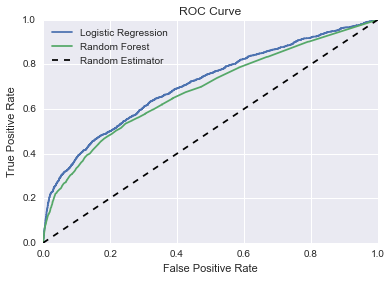

In [44]:
fpr_lr, tpr_lr, thresholds = sklearn.metrics.roc_curve(ytest, lr.predict_proba(Xtest)[:, 1])
fpr_rf, tpr_rf, thresholds = sklearn.metrics.roc_curve(ytest, rf.predict_proba(Xtest)[:, 1])

print "Logistic Regression AUC: %f" % sklearn.metrics.auc(fpr_lr, tpr_lr)
print "Random Forest AUC: %f" % sklearn.metrics.auc(fpr_rf, tpr_rf)
fig, ax = pyplot.subplots()
pyplot.plot(fpr_lr,tpr_lr, label="Logistic Regression")
pyplot.plot(fpr_rf,tpr_rf, label="Random Forest")
pyplot.plot([0, 1], [0, 1], 'k--', label='Random Estimator')
legend = ax.legend(loc='upper left', shadow=True)
pyplot.title('ROC Curve')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

### Cross-validation

We previously decided to randomly split the data to evaluate the model on 25% of held-out data. However the location randomness of the split might have a significant impact in the estimated accuracy.

So instead of using a single train / test split, we can use a group of them and compute mean scores.

In [45]:
print "k-fold mean AUC for Logistic Regression: %f" % sklearn.cross_validation.cross_val_score(lr, X, y, cv=5, scoring='roc_auc', n_jobs=8).mean()
print "k-fold mean AUC for Random Forest: %f" % sklearn.cross_validation.cross_val_score(rf, X, y, cv=5, scoring='roc_auc', n_jobs=8).mean()

k-fold mean AUC for Logistic Regression: 0.683257
k-fold mean AUC for Random Forest: 0.635998


## (Automated) Parameter Tuning

To optimize the classification, we will perform a grid search accross a series of possible values for 'max_depth' and 'criterion' parameters of the Random Forest algorithm.

In [46]:
from sklearn.grid_search import GridSearchCV
params = {
    'rf__criterion' : ['gini', 'entropy'],
    'rf__max_depth': range(2, 10)
}

tun = GridSearchCV(rf, params, cv=5, scoring='roc_auc', n_jobs=8)
tun.fit(X, y)
sorted(tun.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

[mean: 0.69533, std: 0.08937, params: {'rf__criterion': 'gini', 'rf__max_depth': 2},
 mean: 0.69464, std: 0.08546, params: {'rf__criterion': 'entropy', 'rf__max_depth': 2},
 mean: 0.69398, std: 0.09208, params: {'rf__criterion': 'gini', 'rf__max_depth': 3},
 mean: 0.69391, std: 0.10223, params: {'rf__criterion': 'gini', 'rf__max_depth': 5},
 mean: 0.69390, std: 0.09049, params: {'rf__criterion': 'entropy', 'rf__max_depth': 3},
 mean: 0.69382, std: 0.10109, params: {'rf__criterion': 'entropy', 'rf__max_depth': 5},
 mean: 0.69138, std: 0.10333, params: {'rf__criterion': 'entropy', 'rf__max_depth': 6},
 mean: 0.69092, std: 0.09662, params: {'rf__criterion': 'gini', 'rf__max_depth': 4},
 mean: 0.68949, std: 0.10577, params: {'rf__criterion': 'gini', 'rf__max_depth': 6},
 mean: 0.68881, std: 0.09850, params: {'rf__criterion': 'entropy', 'rf__max_depth': 4},
 mean: 0.68861, std: 0.10801, params: {'rf__criterion': 'gini', 'rf__max_depth': 7},
 mean: 0.68744, std: 0.10757, params: {'rf__criter

Now, we compare the performance of this 'tuned model' with the previous ones:

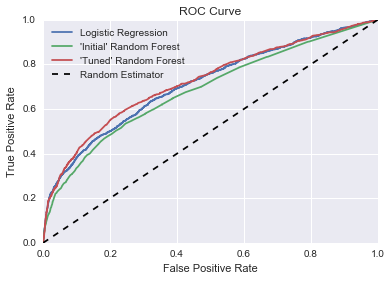

In [48]:
fig, ax = pyplot.subplots()
fpr_tun, tpr_tun, thresholds = sklearn.metrics.roc_curve(ytest, tun.predict_proba(Xtest)[:, 1])
pyplot.plot(fpr_lr,tpr_lr, label = "Logistic Regression")
pyplot.plot(fpr_rf,tpr_rf, label="'Initial' Random Forest")
pyplot.plot(fpr_tun,tpr_tun, label = "'Tuned' Random Forest")
pyplot.plot([0, 1], [0, 1], 'k--', label='Random Estimator')
pyplot.title('ROC Curve')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
legend = ax.legend(loc='upper left', shadow=True)

## Feature Importance

The feature importance give us a measure of the (relative) impact that a given feature have in the overal algorithm's score.

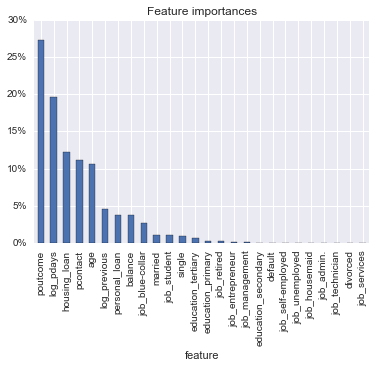

In [49]:
ax = pd.Series(tun.best_estimator_.steps[1][1].feature_importances_, index=features.columns).sort_values(ascending=False).plot.bar()
ax.yaxis.set_major_formatter(pyplot.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
pyplot.title('Feature importances')
pyplot.xlabel('feature')